<a href="https://colab.research.google.com/github/azamjon98/final_project/blob/ava_tickets/avia_ticket_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
encoder=OrdinalEncoder()

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

from sklearn.linear_model import LinearRegression
lr=LinearRegression()

from sklearn.tree import DecisionTreeRegressor
dt=DecisionTreeRegressor()

from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor()

from sklearn.metrics import mean_squared_error,r2_score

import warnings
warnings.filterwarnings('ignore')

In [4]:
path='/content/train_data.csv'
train=pd.read_csv(path)


In [5]:
test=pd.read_csv('/content/test_data.csv')
test.head()

,id,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left
0,1,Air_India,AI-765,Kolkata,Evening,one,Night,Delhi,Business,28.25,2
1,2,Vistara,UK-747,Delhi,Early_Morning,one,Night,Mumbai,Business,13.83,34
2,3,Air_India,AI-570,Mumbai,Early_Morning,zero,Early_Morning,Chennai,Business,2.00,30
3,4,AirAsia,I5-974,Hyderabad,Night,one,Late_Night,Delhi,Economy,5.17,26
4,5,Air_India,AI-770,Kolkata,Night,one,Afternoon,Mumbai,Economy,16.33,35


In [6]:
train.shape,test.shape

((20000, 12), (5000, 11))

In [7]:
df=train.copy()
df=df.drop(['id','flight'],axis=1)
df.head()
# we do not need id and flight columns, we have index so we can drop id, flight is just a code number of airplane

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,Vistara,Bangalore,Early_Morning,one,Night,Mumbai,Economy,14.25,21,7212
1,SpiceJet,Hyderabad,Evening,zero,Night,Kolkata,Economy,1.75,7,5292
2,Vistara,Bangalore,Morning,one,Evening,Delhi,Business,9.58,5,60553
3,Vistara,Kolkata,Morning,one,Evening,Hyderabad,Economy,6.75,28,5760
4,Indigo,Chennai,Early_Morning,zero,Morning,Mumbai,Economy,2.00,4,10712


## Descriptive analysis

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   airline           20000 non-null  object 
 1   source_city       20000 non-null  object 
 2   departure_time    20000 non-null  object 
 3   stops             20000 non-null  object 
 4   arrival_time      20000 non-null  object 
 5   destination_city  20000 non-null  object 
 6   class             20000 non-null  object 
 7   duration          20000 non-null  float64
 8   days_left         20000 non-null  int64  
 9   price             20000 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 1.5+ MB


### We do not have nan values. Data set is clear

* Here price and duration columns have continuous data
* days_left has  discrete data
* other columns has  categorical data
* Later we convert those categorical data into discrete


In [8]:
col=df.columns
for i in range(10):
    print(col[i])
    print(df[col[i]].unique()) # prints all unique values
    print(df[col[i]].nunique())
    print('-'*60)


airline
['Vistara' 'SpiceJet' 'Indigo' 'Air_India' 'GO_FIRST' 'AirAsia']
6
------------------------------------------------------------
source_city
['Bangalore' 'Hyderabad' 'Kolkata' 'Chennai' 'Delhi' 'Mumbai']
6
------------------------------------------------------------
departure_time
['Early_Morning' 'Evening' 'Morning' 'Afternoon' 'Night' 'Late_Night']
6
------------------------------------------------------------
stops
['one' 'zero' 'two_or_more']
3
------------------------------------------------------------
arrival_time
['Night' 'Evening' 'Morning' 'Afternoon' 'Early_Morning' 'Late_Night']
6
------------------------------------------------------------
destination_city
['Mumbai' 'Kolkata' 'Delhi' 'Hyderabad' 'Chennai' 'Bangalore']
6
------------------------------------------------------------
class
['Economy' 'Business']
2
------------------------------------------------------------
duration
[14.25  1.75  9.58  6.75  2.   20.42 18.42  2.58 15.92 16.5  24.25 19.67
  1.58  7.5   9

In [9]:
df.describe()

,duration,days_left,price
count,20000.000000,20000.000000,20000.000000
mean,12.177627,25.924150,20960.281700
std,7.157944,13.624874,22775.459535
min,0.830000,1.000000,1105.000000
25%,6.830000,14.000000,4783.000000
50%,11.250000,26.000000,7425.000000
75%,16.080000,38.000000,42521.000000
max,38.580000,49.000000,114523.000000


### From above we can conclude that our data is right skewed, and there are lots of extreme values that can disturb our prediction.

### Days_left column is symmetric, however it is discrete data so we cannot use normal distribution for it



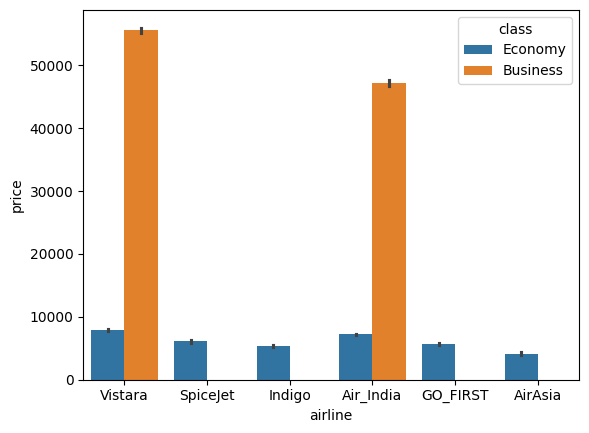

In [10]:
sns.barplot(data=df, x='airline', y='price',hue='class',estimator='mean')
plt.show()

### Here only Vistara and Air_India companies have all classes,  while others have only Economy class and, Business class is much more expencive compare to the Economy. This discrepancy migt make difficult to predict. If so we will divide our dataset according to class.



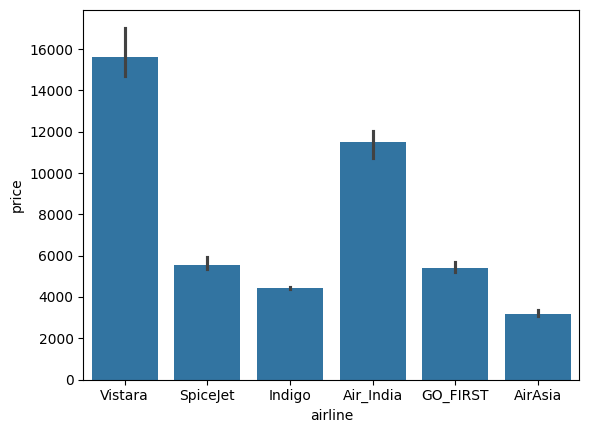

In [11]:
sns.barplot(data=df, x='airline', y='price',estimator='median')
plt.show()

### Vistara and Air_India have much more expencive tickets compare to the others

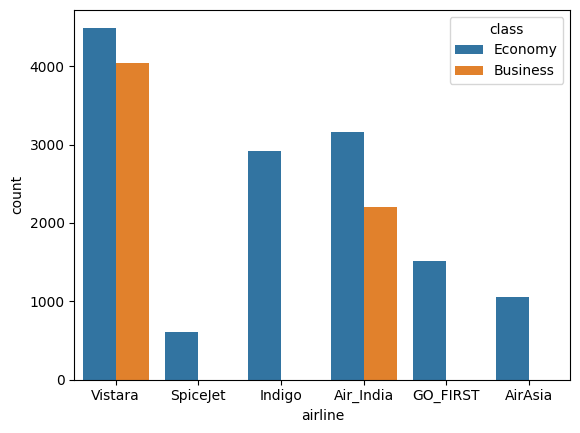

In [13]:
sns.countplot(data=df,x='airline',hue='class')
plt.show()

### As well as prices, Vistara and Air_India have greatest contrabution in the number of flights

# How is the price affected when tickets are bought in just 1 or 2 days before departure?

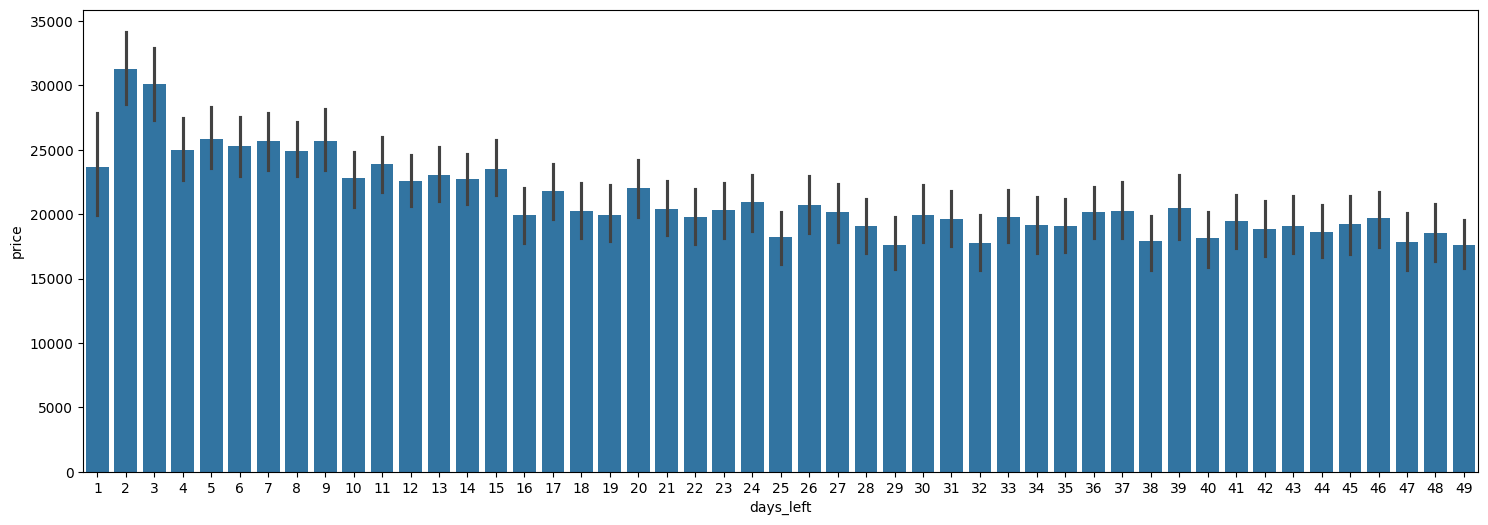

In [14]:
plt.figure(figsize=(18,6))
sns.barplot(data=df, x='days_left', y='price',estimator='mean')
plt.show()

### Days left has a minor effect on prices. If you buy 40+ day before it might be a bit cheaper than other days, and the most expencive tickets can be sold 2 or 3 days before flight.

### Does ticket price change based on the departure time and arrival

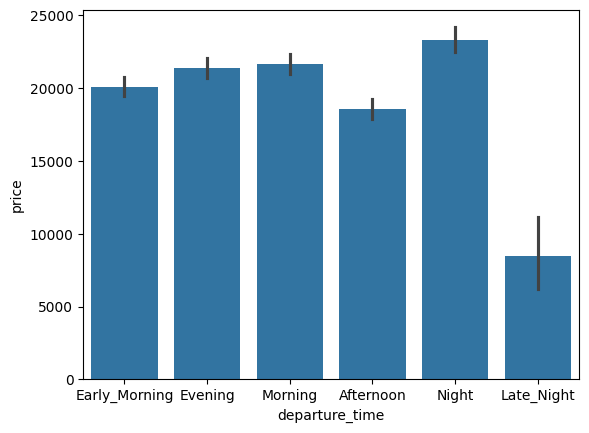

In [15]:
sns.barplot(data=df, x='departure_time', y='price',estimator='mean')
plt.show()

###  prices of departing  at Late_night are more cheaper than other times

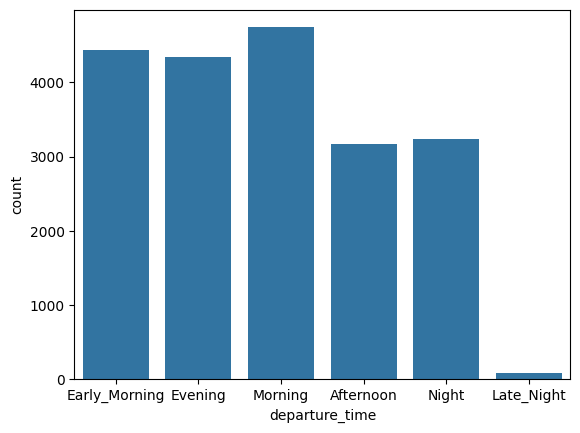

In [16]:
sns.countplot(data=df, x='departure_time')
plt.show()

### however there are very few flights at late_night

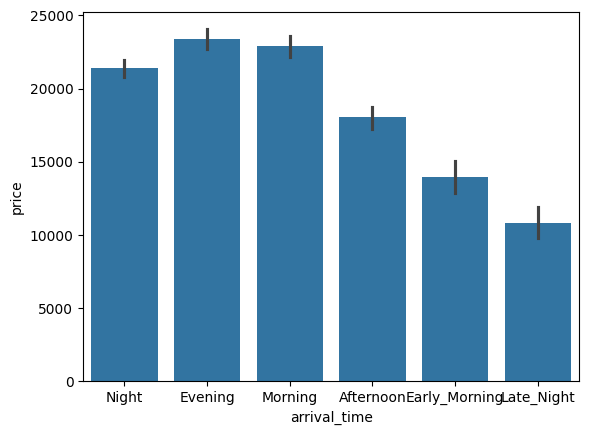

In [17]:
sns.barplot(data=df, x='arrival_time', y='price',estimator='mean')
plt.show()

### price of flying when you arrive at late_night and in the early morning are cheper than other times,
### other prices are fairly equal to each other

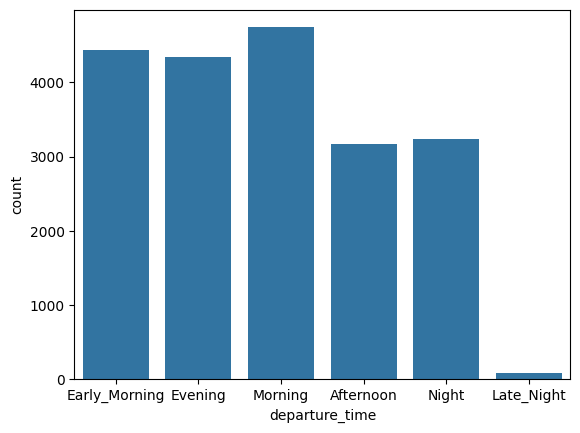

In [18]:
sns.countplot(data=df, x='departure_time')
plt.show()

### however there are very few flights  if you arrive at late_night

# How the price changes with change in Source and Destination?

In [19]:
count=df.groupby(['source_city','destination_city']).count()
sum1=df.groupby(['source_city','destination_city']).sum()
pd.DataFrame(sum1['price']/count['price'])

price
source_city destination_city              
Bangalore   Chennai           22843.469298
            Delhi             17885.118778
            Hyderabad         20768.676056
            Kolkata           25487.040359
            Mumbai            23019.570957
Chennai     Bangalore         23608.389952
            Delhi             17288.464724
            Hyderabad         21347.560185
            Kolkata           23601.053388
            Mumbai            22972.751261
Delhi       Bangalore         18076.254237
            Chennai           19980.980822
            Hyderabad         16523.927184
            Kolkata           21336.538366
            Mumbai            19028.188583
Hyderabad   Bangalore         20408.235622
            Chennai           20358.050114
            Delhi             15634.680556
            Kolkata           20774.573832
            Mumbai            19278.103187
Kolkata     Bangalore         22862.650075
            Chennai           23760.862832
            Delhi             18335.943741
            Hyderabad         20090.357724
            Mumbai            22621.145995
Mumbai      Bangalore         24353.434783
            Chennai           24269.231392
            Delhi             19433.437126
            Hyderabad         21709.090909
            Kolkata           23945.269417

### We can see that going and returning ticket prices can differ by no more than 5000 units

### How does the ticket price vary between Economy and Business class?

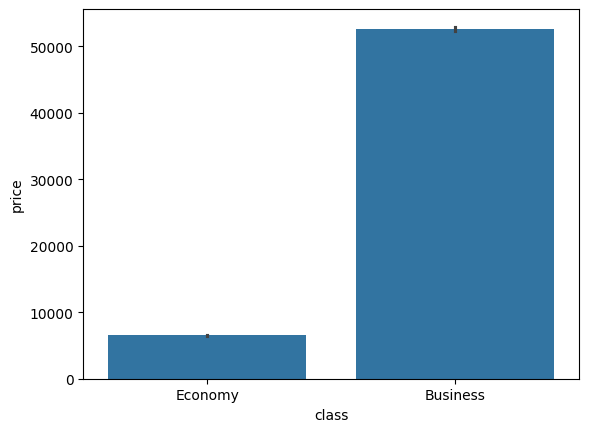

In [20]:
sns.barplot(data=df,x='class',y='price')
plt.show()

###  there is a huge difference between ticket prices of Economy and Business class

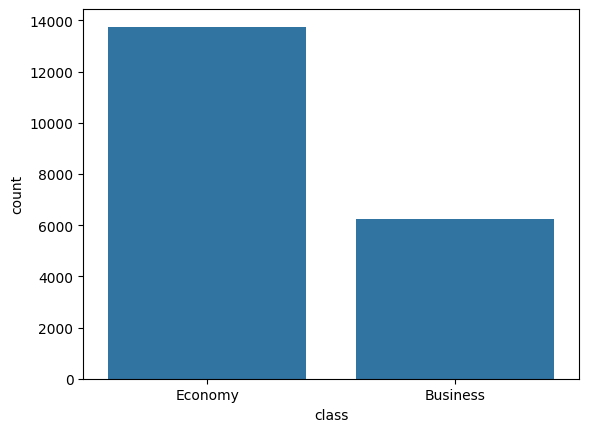

In [21]:
sns.countplot(data=df,x='class')
plt.show()

### there are much more Economy class tickets are available compare to the Business one

### We have already checked that our data is highly right skewed

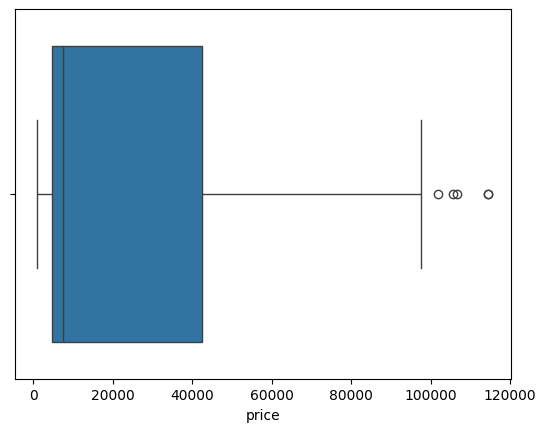

In [22]:
x=df['price'].sort_values()
sns.boxplot(x=x)
plt.show()

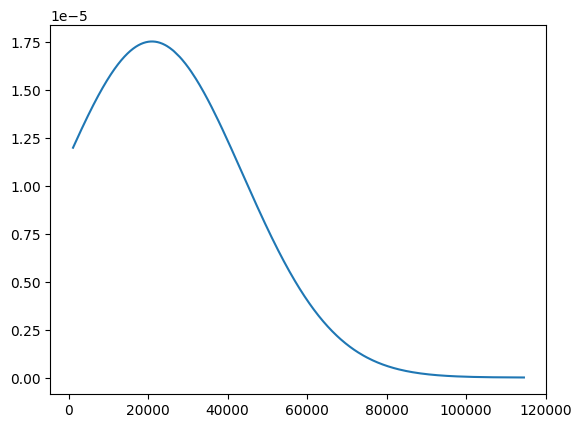

In [23]:
from scipy.stats import norm
x=df['price'].sort_values()
y=norm.pdf(x,loc=x.mean(),scale=x.std())
plt.plot(x,y)
plt.show()

### To avoid skewness we apply-- IQR, z-score and log methods

In [27]:
# Excluding outliers by using IQR method
q1,q3=df['price'].quantile([0.25,0.75])
iqr=q3-q1
low_b=q1-1.5*iqr  # define lower bound
up_b=q3+1.5*iqr   # define upper bound
mask=(df['price']>=low_b) & (df['price']<=up_b)   # create a filter
df_n=df[mask]

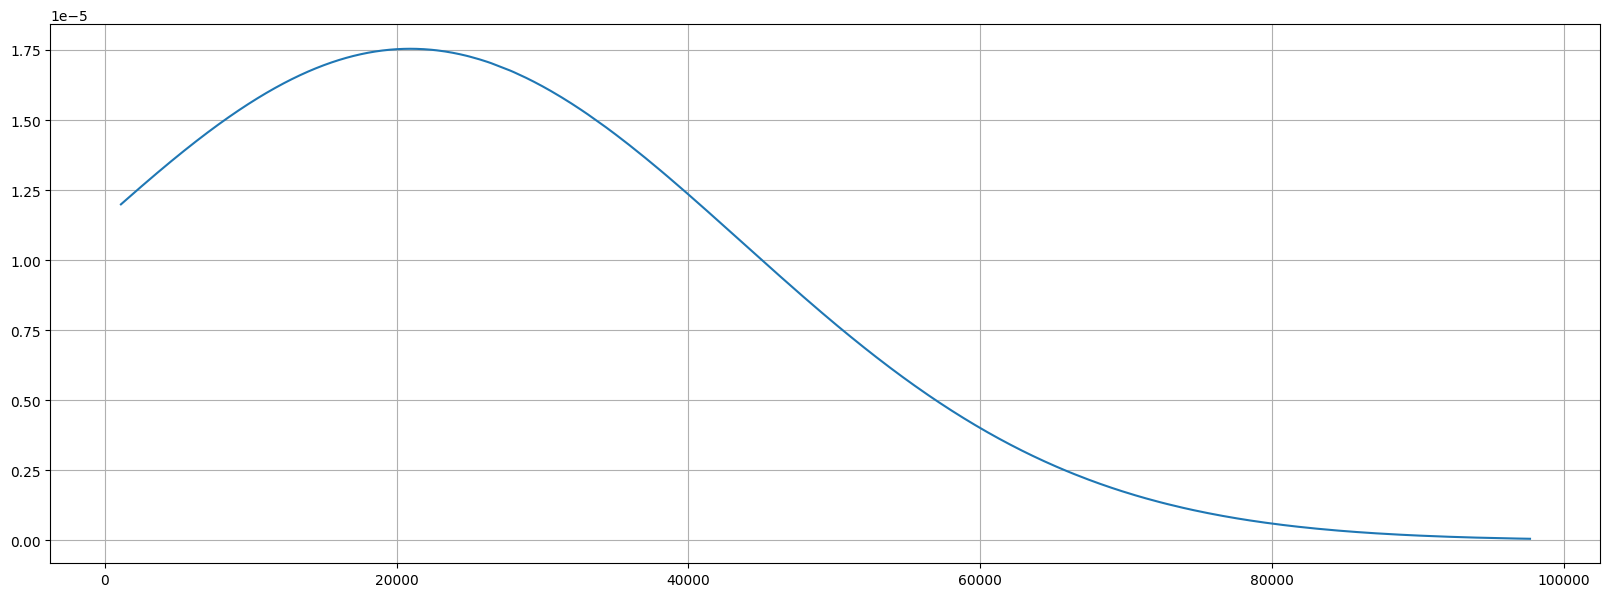

In [28]:
x=df_n['price'].sort_values()   # define x axis
y=norm.pdf(x,loc=x.mean(), scale=x.std())  # find values of y axis, it is probability
plt.figure(figsize=(20,7)) # plotting
plt.plot(x,y)
plt.grid()
plt.show()

In [29]:
# Excluding outliers by using z_score method
z=(df['price']-df['price'].mean())/df['price'].std()  # find z scores of price column
low_b=z>=-3  # define lower bound
up_b=z<=3    # define upper bound
mask=low_b & up_b  # create a filter
df_nz=df[mask]

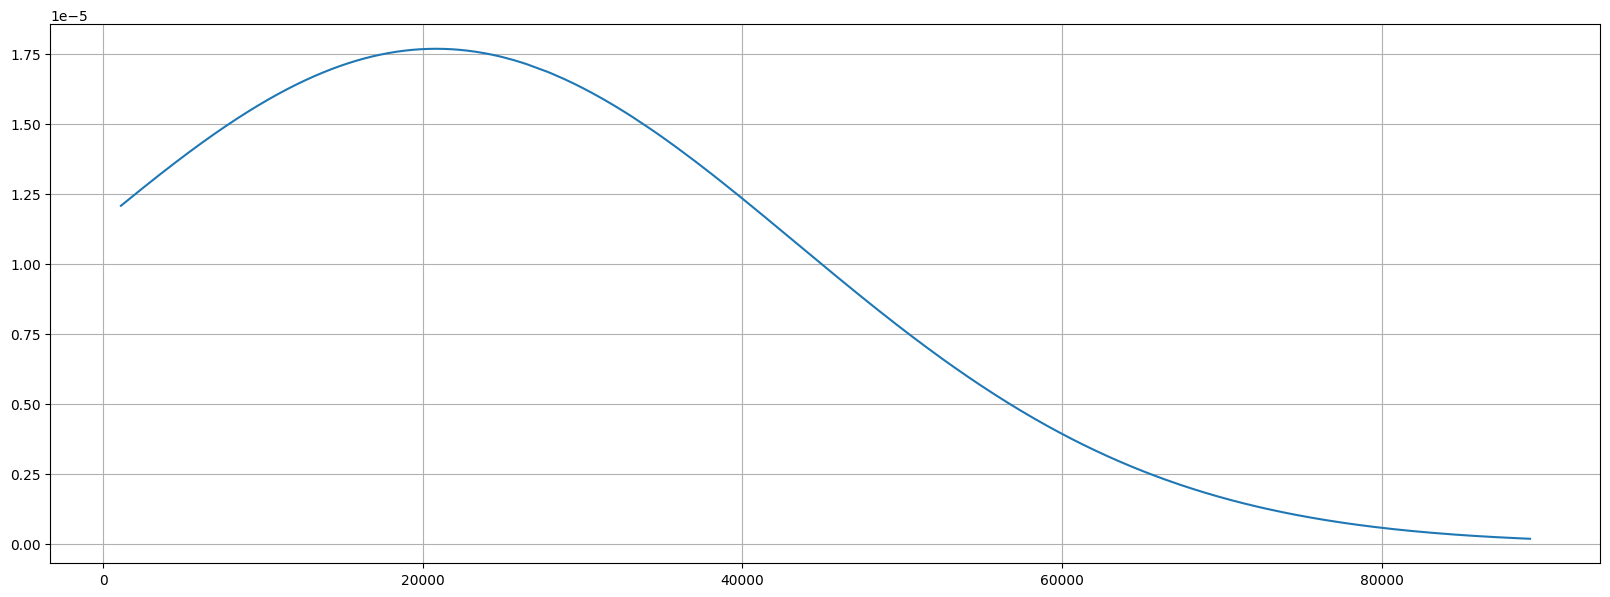

In [30]:
x=df_nz['price'].sort_values()  # define x axis
y=norm.pdf(x,loc=x.mean(), scale=x.std())  # find values of y axis, it is probability
plt.figure(figsize=(20,7)) # plotting
plt.plot(x,y)
plt.grid()
plt.show()

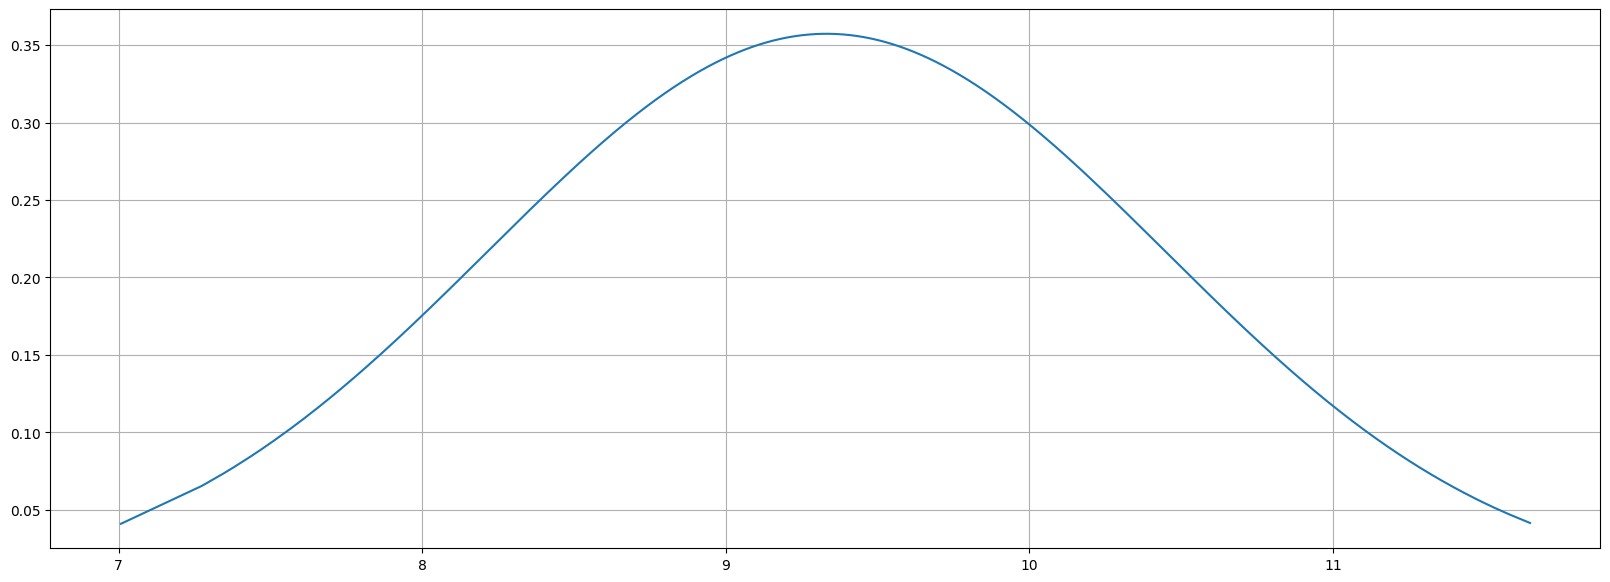

In [31]:
# Excluding outliers by using log method
target=np.log(df['price'])
x=target.copy()
x=x.sort_values()  # define x axis
y=norm.pdf(x,loc=x.mean(), scale=x.std())  # find values of y axis, it is probability
plt.figure(figsize=(20,7)) # plotting
plt.plot(x,y)
plt.grid()
plt.show()

### We can see that last one is the best method in our problem

# Preprocessing

### We will convert all categorical data into numerical by using OrdinalEncoder, and pd.get_dummies()

* By using OrdinalEncoder:   flight_country',   'stops','   class',
   'departure_time',  'arrival_time'-- columns, because here is an order.

* Via pd.get_dummies() :'airline', 'source_city', 'destination_city' --columns, becouse here there is no any order.

### Then we will drop 'id' and 'flight' columns. Then we will convert all features into z scores by using StandardScaler()
### We should take as target np.log(df['price]) because we should  treat skewness.

In [10]:
def preparing(df):
    df[['flight_country', 'flight_number']]=df["flight"].str.split("-", expand=True)
    df['flight_number']=df['flight_number'].astype('int64')

    ordinal_encoder = df[['flight_country','stops','class','departure_time', 'arrival_time']]
    df[['flight_country','stops','class','departure_time', 'arrival_time']] = encoder.fit_transform(ordinal_encoder)

    not_ordinal = ['airline', 'source_city', 'destination_city']
    df = pd.get_dummies(df, columns=not_ordinal, dtype=float)

    df.drop(['id','flight'], axis=1, inplace=True)

    if 'price' in df.columns:
        y = np.log(df['price'])
        df.drop('price', axis=1, inplace=True)
    else:
        y = None

    X_n = df.copy()


    X_n[X_n.columns]=scaler.fit_transform(X_n[X_n.columns])

    return X_n,y

In [11]:
X,y=preparing(train)
X.head()

,departure_time,stops,arrival_time,class,duration,days_left,flight_country,flight_number,airline_AirAsia,airline_Air_India,...,source_city_Delhi,source_city_Hyderabad,source_city_Kolkata,source_city_Mumbai,destination_city_Bangalore,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,destination_city_Mumbai
0,-0.811824,-0.430679,1.106691,0.673965,0.289528,-0.361418,1.060732,-0.307081,-0.2361,-0.605927,...,-0.501718,-0.399106,-0.427635,-0.505307,-0.454573,-0.394633,-0.486288,-0.404645,-0.446382,2.025992
1,-0.242063,2.552893,1.106691,0.673965,-1.456827,-1.388976,0.571307,1.867123,-0.2361,-0.605927,...,-0.501718,2.505598,-0.427635,-0.505307,-0.454573,-0.394633,-0.486288,-0.404645,2.240236,-0.493585
2,0.897459,-0.430679,-0.615250,-1.483758,-0.362910,-1.535770,1.060732,-0.288811,-0.2361,-0.605927,...,-0.501718,-0.399106,-0.427635,-0.505307,-0.454573,-0.394633,2.056394,-0.404645,-0.446382,-0.493585
3,0.897459,-0.430679,-0.615250,0.673965,-0.758285,0.152361,1.060732,-0.359863,-0.2361,-0.605927,...,-0.501718,-0.399106,2.338441,-0.505307,-0.454573,-0.394633,-0.486288,2.471299,-0.446382,-0.493585
4,-0.811824,2.552893,0.532711,0.673965,-1.421900,-1.609167,-1.386396,2.019378,-0.2361,-0.605927,...,-0.501718,-0.399106,-0.427635,-0.505307,-0.454573,-0.394633,-0.486288,-0.404645,-0.446382,2.025992


# Prediction and Evalution

In [300]:
trainx,testx,trainy,testy=train_test_split(X,y,test_size=0.2,random_state=42)

RMSE= 3283.1485754013406
R2_score= 0.9794729808768665
correlation coefficient 0.9897004551302467


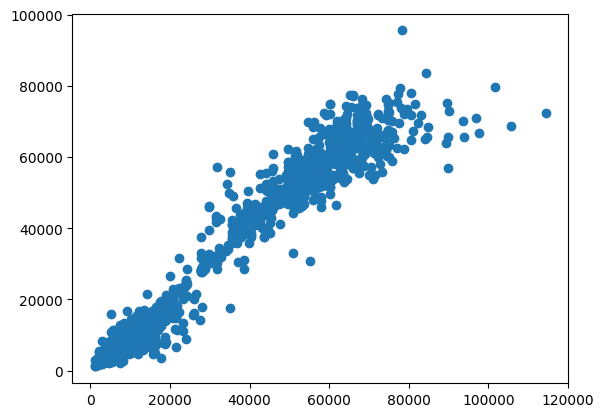

In [301]:
# predicting by random_forest_regressor
model_rf=rf.fit(trainx,trainy)  # define a model
pred=model_rf.predict(testx) # do prediction
testy1=np.exp(testy)   # it was in log so we return into original format
pred1=np.exp(pred)

# checking metrics
print('RMSE=',np.sqrt(mean_squared_error(testy1,pred1)))
print('R2_score=',r2_score(testy1,pred1))
print('correlation coefficient',np.corrcoef(testy1,pred1)[1,0])

# plotting
plt.scatter(testy1,pred1)
plt.show()

RMSE= 8956.500884761082
R2_score= 0.8472358106617643
correlation coefficient 0.924854278252823


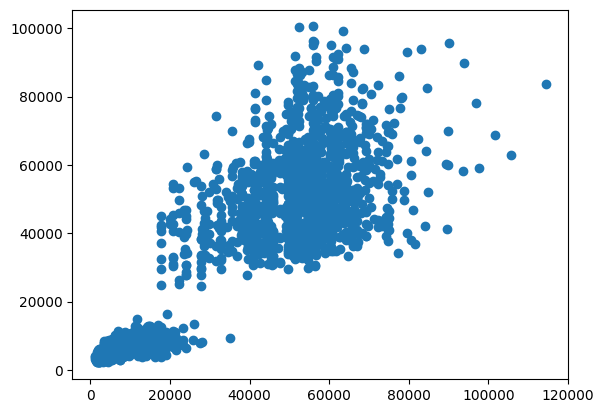

In [302]:
# predicting by linear regression
model_lr=lr.fit(trainx,trainy)  # define a model
pred=model_lr.predict(testx) # do prediction
testy1=np.exp(testy)   # it was in log so we return into original format
pred1=np.exp(pred)

# checking metrics
print('RMSE=',np.sqrt(mean_squared_error(testy1,pred1)))
print('R2_score=',r2_score(testy1,pred1))
print('correlation coefficient',np.corrcoef(testy1,pred1)[1,0])

# plotting
plt.scatter(testy1,pred1)
plt.show()

RMSE= 4187.261191361993
R2_score= 0.9666108842684032
correlation coefficient 0.9833691889951319


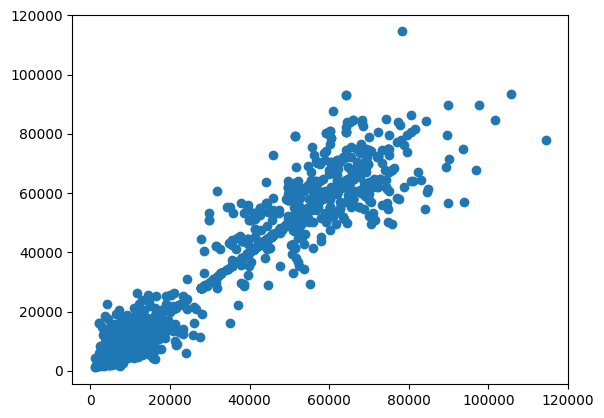

In [303]:
# predicting by decision_tree_regressor
model_dt=dt.fit(trainx,trainy)  # define a model
pred=model_dt.predict(testx) # do prediction
testy1=np.exp(testy)   # it was in log so we return into original format
pred1=np.exp(pred)

# checking metrics
print('RMSE=',np.sqrt(mean_squared_error(testy1,pred1)))
print('R2_score=',r2_score(testy1,pred1))
print('correlation coefficient',np.corrcoef(testy1,pred1)[1,0])

# plotting
plt.scatter(testy1,pred1)
plt.show()

In [13]:
test_data,y=preparing(test)
test_data.head()

,departure_time,stops,arrival_time,class,duration,days_left,flight_country,flight_number,airline_AirAsia,airline_Air_India,...,source_city_Delhi,source_city_Hyderabad,source_city_Kolkata,source_city_Mumbai,destination_city_Bangalore,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,destination_city_Mumbai
0,-0.214782,-0.415062,1.111881,-1.508109,2.179304,-1.754111,-0.877622,-0.329982,-0.235628,1.605160,...,-0.500625,-0.395394,2.324231,-0.505619,-0.471693,-0.389285,2.086461,-0.406818,-0.449037,-0.484007
1,-0.788144,-0.415062,1.111881,-1.508109,0.205481,0.583184,1.089037,-0.339196,-0.235628,-0.622991,...,1.997503,-0.395394,-0.430250,-0.505619,-0.471693,-0.389285,-0.479280,-0.406818,-0.449037,2.066084
2,-0.788144,2.627911,-1.175940,-1.508109,-1.413821,0.291022,-0.877622,-0.429794,-0.235628,1.605160,...,-0.500625,-0.395394,-0.430250,1.977774,-0.471693,2.568810,-0.479280,-0.406818,-0.449037,-0.484007
3,1.505306,-0.415062,-0.032029,0.663082,-0.979909,-0.001139,0.105708,-0.223005,4.243985,-0.622991,...,-0.500625,2.529120,-0.430250,-0.505619,-0.471693,-0.389285,2.086461,-0.406818,-0.449037,-0.484007
4,1.505306,-0.415062,-1.747895,0.663082,0.547683,0.656225,-0.877622,-0.327423,-0.235628,1.605160,...,-0.500625,-0.395394,2.324231,-0.505619,-0.471693,-0.389285,-0.479280,-0.406818,-0.449037,2.066084


In [14]:
sub=pd.read_csv('/content/sample_solution.csv')
sub.head()

,id,price
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [12]:
modelrf=rf.fit(X,y)

In [17]:
preds=modelrf.predict(test_data)
preds1=np.exp(preds)
sub['price']=preds1
sub.to_csv('/submission2.csv',index=False)

In [18]:
pd.read_csv('/submission2.csv')

,id,price
0,1,55286.966182
1,2,62200.479370
2,3,23437.915242
3,4,2430.709164
4,5,5621.363059
...,...,...
4995,4996,60630.426516
4996,4997,4219.699045
4997,4998,50271.567422
4998,4999,48004.360966
